In [1]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model
from tensorflow.keras import applications
import tensorflow as tf
from tqdm import tqdm
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import random
from shutil import copyfile
import os
import gc
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from keras import backend as K

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import style
import seaborn as sns
from keras.callbacks import ModelCheckpoint
#configure
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

In [3]:
import os
print(os.listdir('D:/Python3.7/flowers'))

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


In [4]:
X=[]
y=[]
IMG_SIZE=150
DAISY_DIR='D:/Python3.7/flowers/daisy'
SUNFLOWER_DIR='D:/Python3.7/flowers/sunflower'
TULIP_DIR='D:/Python3.7/flowers/tulip'
DANDI_DIR='D:/Python3.7/flowers/dandelion'
ROSE_DIR='D:/Python3.7/flowers/rose'


In [5]:
def assigning_label(img,flower_type):
    return flower_type

In [6]:
def make_train_data(flower_type,DIR):
    for img in tqdm(os.listdir(DIR)):
        label=assigning_label(img,flower_type)
        path = os.path.join(DIR,img)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        
        X.append(np.array(img))
        y.append(str(label))

In [7]:
#create training data
make_train_data('Daisy',DAISY_DIR)
make_train_data('Sunflowers',SUNFLOWER_DIR)
make_train_data('Tulips',TULIP_DIR)
make_train_data('dandelion',DANDI_DIR)
make_train_data('Roses',ROSE_DIR)
print(len(X))

100%|███████████████████████████████████████████████████████████████████████████████| 784/784 [00:01<00:00, 609.05it/s]


4315


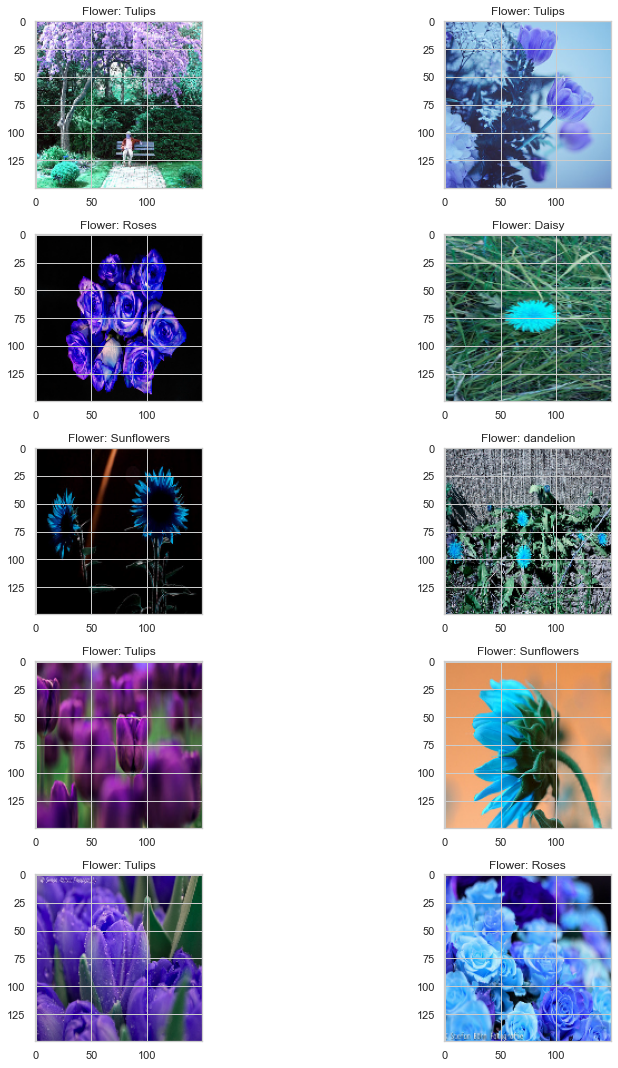

In [8]:
import random as rn
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (2):
        l=rn.randint(0,len(y))
        ax[i,j].imshow(X[l])
        ax[i,j].set_title('Flower: '+y[l])
        
plt.tight_layout()

In [9]:
from sklearn.preprocessing import LabelEncoder

labelEncoder=LabelEncoder()
y=labelEncoder.fit_transform(y)
y=to_categorical(y,5)
X=np.array(X)
X=X/255

In [10]:
X.shape

(4315, 150, 150, 3)

In [11]:
y.shape

(4315, 5)

In [12]:
X_train_val,X_test,y_train_val,y_test=train_test_split(X,y,test_size=0.25,random_state=42)
X_train,X_val,y_train,y_val=train_test_split(X_train_val,y_train_val,test_size=0.10,random_state=42)

In [13]:
X_train.shape

(2912, 150, 150, 3)

In [14]:
y_train.shape

(2912, 5)

In [15]:
# VGG16 pre-trained model without fully connected layers 
image_w, image_h = 150,150
model = applications.VGG16(weights = "imagenet", include_top=False, input_shape = (image_w, image_h, 3))

In [16]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [17]:
for layer in model.layers:
    layer.trainable = False
    
for i, layer in enumerate(model.layers):
    print(i, layer.name, layer.trainable)

0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 False
16 block5_conv2 False
17 block5_conv3 False
18 block5_pool False


In [18]:
def Revised_1_fn(learn_rate=0.01): 
    last = model.output
    x = Flatten()(last)
    x = Dense(256, activation='relu', name='new_fc1', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = Dropout(0.5)(x)
    preds = Dense(5, activation='softmax')(x)

    Revised_Model_1 = Model(model.input, preds)
    Revised_Model_1.summary()
    Revised_Model_1.compile(loss = "categorical_crossentropy", optimizer = 'Adam', metrics=["accuracy"])
    return Revised_Model_1

In [19]:
#using Grid Search and Early stopping
es = EarlyStopping(monitor='val_accuracy', verbose=2, patience=25)
mc = ModelCheckpoint('./best_model_1.h5', monitor='val_accuracy', verbose=2, save_best_only=True)

Hyp_Model_1 = KerasClassifier(build_fn=Revised_1_fn)

learn_rate = [0.01]
batch_size = [32,75,100]
epochs = [5]

param_grid = dict(batch_size=batch_size, epochs=epochs, learn_rate = learn_rate)
randSearch_1 = GridSearchCV(estimator = Hyp_Model_1, param_grid=param_grid, cv=5)

In [20]:
new_grid_1 = randSearch_1.fit(X_train,y_train, validation_data = (X_val, y_val), verbose=1,callbacks=[es,mc])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

73/73 [==============================] - 130s 2s/step - loss: 1.4132 - accuracy: 0.7565 - val_loss: 1.2155 - val_accuracy: 0.7593

Epoch 00002: val_accuracy did not improve from 0.79012
Epoch 3/5
73/73 [==============================] - 137s 2s/step - loss: 1.1109 - accuracy: 0.7733 - val_loss: 1.0302 - val_accuracy: 0.8056

Epoch 00003: val_accuracy improved from 0.79012 to 0.80556, saving model to .\best_model_1.h5
Epoch 4/5
73/73 [==============================] - 135s 2s/step - loss: 1.0019 - accuracy: 0.7823 - val_loss: 1.0068 - val_accuracy: 0.7778

Epoch 00004: val_accuracy did not improve from 0.80556
Epoch 5/5
73/73 [==============================] - 136s 2s/step - loss: 0.9822 - accuracy: 0.7746 - val_loss: 1.1504 - val_accuracy: 0.6914

Epoch 00005: val_accuracy did not improve from 0.80556
19/19 [==============================] - 30s 2s/step - loss: 1.1373 - accuracy: 0.7033
Model: "model_2"
_________________________________________________________________
Layer (type)     

Epoch 1/5
73/73 [==============================] - 204s 3s/step - loss: 3.0516 - accuracy: 0.6090 - val_loss: 1.7171 - val_accuracy: 0.7438

Epoch 00001: val_accuracy did not improve from 0.80864
Epoch 2/5
73/73 [==============================] - 128s 2s/step - loss: 1.4364 - accuracy: 0.7614 - val_loss: 1.2671 - val_accuracy: 0.7377

Epoch 00002: val_accuracy did not improve from 0.80864
Epoch 3/5
73/73 [==============================] - 130s 2s/step - loss: 1.1402 - accuracy: 0.7691 - val_loss: 1.0547 - val_accuracy: 0.7963

Epoch 00003: val_accuracy did not improve from 0.80864
Epoch 4/5
73/73 [==============================] - 129s 2s/step - loss: 0.9903 - accuracy: 0.7794 - val_loss: 0.9948 - val_accuracy: 0.7809

Epoch 00004: val_accuracy did not improve from 0.80864
Epoch 5/5
73/73 [==============================] - 128s 2s/step - loss: 0.9738 - accuracy: 0.7751 - val_loss: 1.1723 - val_accuracy: 0.7068

Epoch 00005: val_accuracy did not improve from 0.80864
19/19 [=============

Epoch 1/5
32/32 [==============================] - 136s 4s/step - loss: 3.9295 - accuracy: 0.5393 - val_loss: 2.2346 - val_accuracy: 0.7130

Epoch 00001: val_accuracy did not improve from 0.80864
Epoch 2/5
32/32 [==============================] - 136s 4s/step - loss: 1.8612 - accuracy: 0.7140 - val_loss: 1.5572 - val_accuracy: 0.7377

Epoch 00002: val_accuracy did not improve from 0.80864
Epoch 3/5
32/32 [==============================] - 137s 4s/step - loss: 1.3329 - accuracy: 0.7759 - val_loss: 1.1973 - val_accuracy: 0.7809

Epoch 00003: val_accuracy did not improve from 0.80864
Epoch 4/5
32/32 [==============================] - 136s 4s/step - loss: 1.1159 - accuracy: 0.7991 - val_loss: 1.1079 - val_accuracy: 0.7809

Epoch 00004: val_accuracy did not improve from 0.80864
Epoch 5/5
32/32 [==============================] - 137s 4s/step - loss: 0.9844 - accuracy: 0.8115 - val_loss: 0.9936 - val_accuracy: 0.7901

Epoch 00005: val_accuracy did not improve from 0.80864
8/8 [===============

Epoch 1/5
32/32 [==============================] - 145s 5s/step - loss: 4.0122 - accuracy: 0.5352 - val_loss: 2.2252 - val_accuracy: 0.7469

Epoch 00001: val_accuracy did not improve from 0.80864
Epoch 2/5
32/32 [==============================] - 140s 4s/step - loss: 1.8683 - accuracy: 0.7369 - val_loss: 1.6001 - val_accuracy: 0.7253

Epoch 00002: val_accuracy did not improve from 0.80864
Epoch 3/5
32/32 [==============================] - 141s 4s/step - loss: 1.4027 - accuracy: 0.7665 - val_loss: 1.2386 - val_accuracy: 0.7901

Epoch 00003: val_accuracy did not improve from 0.80864
Epoch 4/5
32/32 [==============================] - 141s 4s/step - loss: 1.1367 - accuracy: 0.7940 - val_loss: 1.1015 - val_accuracy: 0.7809

Epoch 00004: val_accuracy did not improve from 0.80864
Epoch 5/5
32/32 [==============================] - 142s 4s/step - loss: 1.0101 - accuracy: 0.7953 - val_loss: 1.0425 - val_accuracy: 0.7840

Epoch 00005: val_accuracy did not improve from 0.80864
8/8 [===============

Epoch 1/5
32/32 [==============================] - 141s 4s/step - loss: 3.5777 - accuracy: 0.6026 - val_loss: 1.9562 - val_accuracy: 0.7623

Epoch 00001: val_accuracy did not improve from 0.80864
Epoch 2/5
32/32 [==============================] - 140s 4s/step - loss: 1.6366 - accuracy: 0.7408 - val_loss: 1.3812 - val_accuracy: 0.7500

Epoch 00002: val_accuracy did not improve from 0.80864
Epoch 3/5
32/32 [==============================] - 140s 4s/step - loss: 1.2281 - accuracy: 0.7841 - val_loss: 1.1506 - val_accuracy: 0.7840

Epoch 00003: val_accuracy did not improve from 0.80864
Epoch 4/5
32/32 [==============================] - 148s 5s/step - loss: 1.0181 - accuracy: 0.7961 - val_loss: 1.0296 - val_accuracy: 0.7963

Epoch 00004: val_accuracy did not improve from 0.80864
Epoch 5/5
32/32 [==============================] - 143s 4s/step - loss: 0.9300 - accuracy: 0.8155 - val_loss: 0.9575 - val_accuracy: 0.7994

Epoch 00005: val_accuracy did not improve from 0.80864
8/8 [===============

Epoch 1/5
24/24 [==============================] - 217s 9s/step - loss: 4.1568 - accuracy: 0.5423 - val_loss: 2.3143 - val_accuracy: 0.7593

Epoch 00001: val_accuracy did not improve from 0.80864
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.9289 - accuracy: 0.7428

Exception ignored in: <function IteratorResourceDeleter.__del__ at 0x000002290342E3A0>
Traceback (most recent call last):
  File "D:\anaconda3\lib\site-packages\tensorflow\python\data\ops\iterator_ops.py", line 545, in __del__
    gen_dataset_ops.delete_iterator(
  File "D:\anaconda3\lib\site-packages\tensorflow\python\ops\gen_dataset_ops.py", line 1262, in delete_iterator
    _result = pywrap_tfe.TFE_Py_FastPathExecute(
KeyboardInterrupt: 


24/24 [==============================] - 215s 9s/step - loss: 1.9289 - accuracy: 0.7428 - val_loss: 1.5721 - val_accuracy: 0.7716

Epoch 00002: val_accuracy did not improve from 0.80864
Epoch 3/5
 1/24 [>.............................] - ETA: 2:23 - loss: 1.3546 - accuracy: 0.8600

KeyboardInterrupt: 

In [21]:
from keras.models import load_model
final_model_1 = load_model('./best_model_1.h5')

In [22]:
# evaluate the model on validation set
val_scores = []
val_scores_1 = final_model_1.evaluate(X_val,y_val, verbose=0)
print("%s: %.2f%%" % (final_model_1.metrics_names[1], val_scores_1[1]*100))
val_scores.append(val_scores_1[1] * 100)

accuracy: 80.86%


In [23]:
# evaluate the model
finalscores = []
final_scores_1 = final_model_1.evaluate(X_test,y_test, verbose=0)
print("%s: %.2f%%" % (final_model_1.metrics_names[1], final_scores_1[1]*100))
finalscores.append(final_scores_1[1] * 100)

accuracy: 79.24%


In [24]:
import gc
gc.collect()

8925

In [27]:
pred=final_model_1.predict(X_test)
pred_digits=np.argmax(pred,axis=1)
act_digits = np.argmax(y_test,axis=1)

In [28]:
# now storing some properly as well as misclassified indexes'.
i=0
prop_class=[]
mis_class=[]

for i in range(len(y_test)):
    if(act_digits[i]==pred_digits[i]):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(y_test)):
    if(not act_digits[i]==pred_digits[i]):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

CORRECTLY CLASSIFIED FLOWER IMAGES

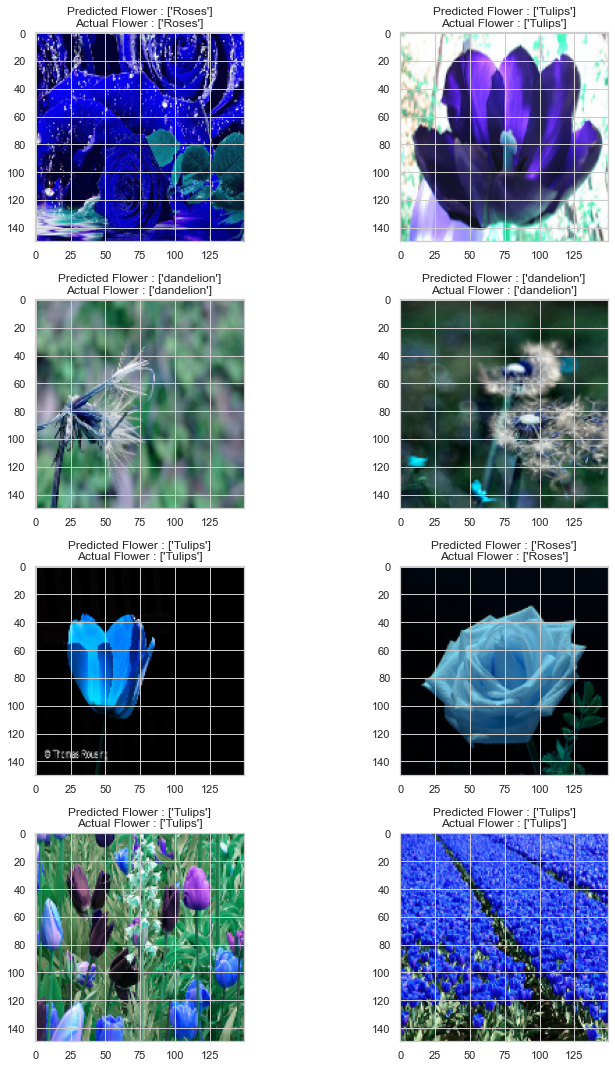

In [29]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(X_test[prop_class[count]])
        ax[i,j].set_title("Predicted Flower : "+str(labelEncoder.inverse_transform([pred_digits[prop_class[count]]])) +"\n"+"Actual Flower : "+str(labelEncoder.inverse_transform([act_digits[prop_class[count]]])))
        plt.tight_layout()
        count+=1

MIS CLASSIFIED FLOWER IMAGES

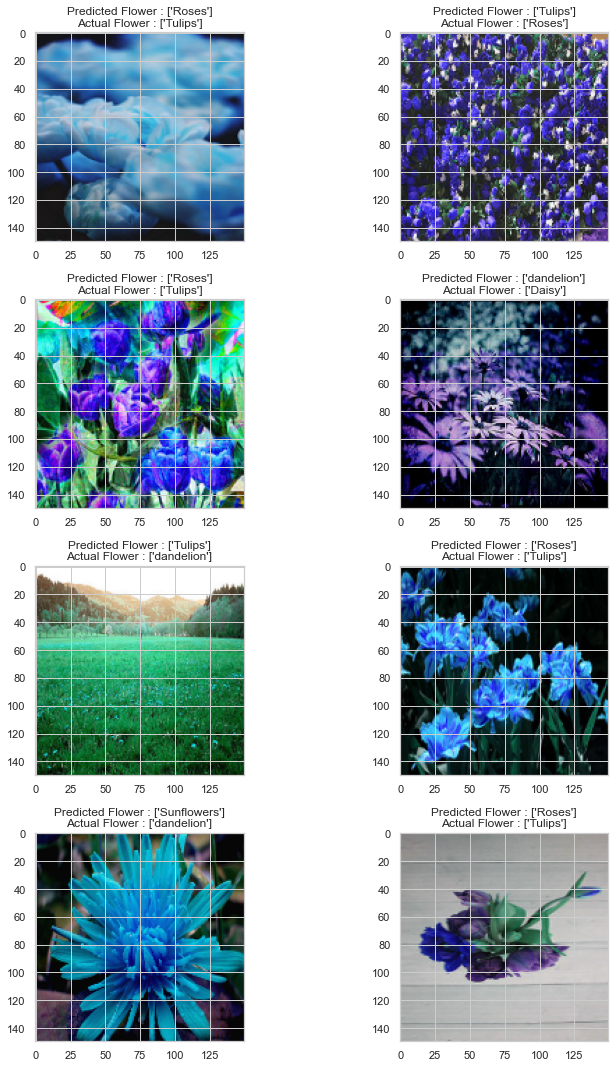

In [30]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(X_test[mis_class[count]])
        ax[i,j].set_title("Predicted Flower : "+str(labelEncoder.inverse_transform([pred_digits[mis_class[count]]])) +"\n"+"Actual Flower : "+str(labelEncoder.inverse_transform([act_digits[mis_class[count]]])))
        plt.tight_layout()
        count+=1